## Problema 1 - generar datos y comparar barras de error


Se piden intervalos de confianza/error bars para varias distribuciones. Genero 2,000 muestras por cada configuracion (3 gaussianas, 2 uniformes, 3 betas) para estimar la media y aplicar Chebyshev y Hoeffding como en el enunciado.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

En este problema queremos construir intervalos de confianza para la media
usando Chebyshev y Hoeffding y comparar los anchos para varias
distribuciones.



**Chebyshev para la media**

Para la media muestral $\bar X$ de una variable con varianza $\sigma^2$:

$$
P(|\bar X - \mu| \ge \varepsilon)
\le \frac{\sigma^2}{n\,\varepsilon^2}.
$$

Si pedimos un nivel $1-\alpha$ y hacemos que el lado derecho sea $\alpha$:

$$
\varepsilon = \sqrt{\frac{\sigma^2}{n\alpha}}.
$$

Como $\sigma^2$ no la sabemos, usamos la **varianza muestral**
$\hat\sigma^2$ y el intervalo de Chebyshev queda:

$$
\bar X \pm \sqrt{\frac{\hat\sigma^2}{n\alpha}}.
$$



**Hoeffding**

Si sabemos que $X_i \in [a,b]$, Hoeffding da:

$$
P(|\bar X - \mu| \ge \varepsilon)
\le 2\exp\!\left(-\frac{2n\varepsilon^2}{(b-a)^2}\right).
$$

Imponiendo nivel $1-\alpha$:

$$
\varepsilon = (b-a)\sqrt{\frac{\ln(2/\alpha)}{2n}},
$$

y el intervalo de Hoeffding es

$$
\bar X \pm (b-a)\sqrt{\frac{\ln(2/\alpha)}{2n}}.
$$

En las uniformesy Betas usamos sus rangos reales $[a,b]$.  
En las normales, como no están acotadas, tomamos un rango aproximado
$\mu \pm 4\sigma$ solo para poder comparar numéricamente con Chebyshev.


In [2]:


def hoeffding_interval(sample, low, high, alpha=0.05):
    n = len(sample)
    width = (high - low) * np.sqrt(np.log(2 / alpha) / (2 * n))
    mean = sample.mean()
    return mean - width, mean + width, 2 * width 

# Chebyshev usaa la varianza muestral (ddof=1) 
def chebyshev_interval(sample, alpha=0.05):
    n=len(sample)
    mean =sample.mean()
    var=sample.var(ddof=1)
    width=np.sqrt(var / (n * alpha))
    return mean - width, mean + width, var, 2 * width

rng=np.random.default_rng(42) 
N=2000
alpha=0.05
rows=[]  
samples={}

# Gaussianas: copio los parametros del ejercicio y acoto con mu +- 4*sigma para poder usar Hoeffding.
for mu, var in [(0, 1), (0, 4), (3, 1)]:
    sigma = np.sqrt(var)
    data = rng.normal(mu, sigma, size=N)
    name = f"Normal(mu={mu}, var={var})"
    samples[name] = data
    cheb_low, cheb_high, var_hat, cheb_width=chebyshev_interval(data, alpha)
    bounds = (mu - 4 * sigma, mu + 4 * sigma)
    hoe_low, hoe_high, hoe_width=hoeffding_interval(data, *bounds, alpha)
    rows.append(dict(
        distribution=name,
        mean_hat=float(data.mean()),
        var_hat=float(var_hat),
        chebyshev_low=cheb_low,
        chebyshev_high=cheb_high,
        chebyshev_width=cheb_width,
        hoeffding_low=hoe_low,
        hoeffding_high=hoe_high,
        hoeffding_width=hoe_width,
        bounds=f"[{bounds[0]:.2f}, {bounds[1]:.2f}]"
    ))

for a, b in [(0, 1), (2, 5)]:
    data = rng.uniform(a, b, size=N)
    name = f"Uniform({a},{b})"
    samples[name] = data
    cheb_low, cheb_high, var_hat, cheb_width=chebyshev_interval(data, alpha)
    hoe_low, hoe_high, hoe_width=hoeffding_interval(data, a, b, alpha)
    rows.append(dict(
        distribution=name,
        mean_hat=float(data.mean()),
        var_hat=float(var_hat),
        chebyshev_low=cheb_low,
        chebyshev_high=cheb_high,
        chebyshev_width=cheb_width,
        hoeffding_low=hoe_low,
        hoeffding_high=hoe_high,
        hoeffding_width=hoe_width,
        bounds=f"[{a:.2f}, {b:.2f}]"
    ))

for a, b in [(0.5, 0.5), (2, 5), (5, 1)]:
    data = rng.beta(a, b, size=N)
    name = f"Beta(alpha={a}, beta={b})"
    samples[name] = data
    cheb_low, cheb_high, var_hat, cheb_width=chebyshev_interval(data, alpha)
    hoe_low, hoe_high, hoe_width=hoeffding_interval(data, 0, 1, alpha)
    rows.append(dict(
        distribution=name,
        mean_hat=float(data.mean()),
        var_hat=float(var_hat),
        chebyshev_low=cheb_low,
        chebyshev_high=cheb_high,
        chebyshev_width=cheb_width,
        hoeffding_low=hoe_low,
        hoeffding_high=hoe_high,
        hoeffding_width=hoe_width,
        bounds="[0.00, 1.00]"
    ))





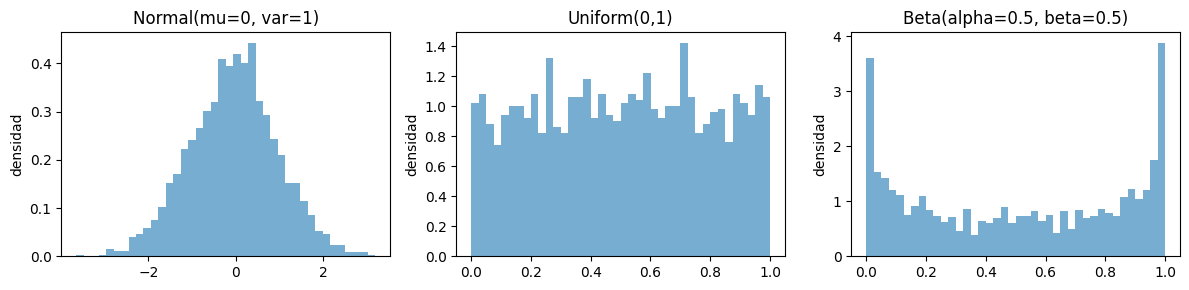

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

dist_names = [
    "Normal(mu=0, var=1)",
    "Uniform(0,1)",
    "Beta(alpha=0.5, beta=0.5)",
]

for ax, name in zip(axes, dist_names):
    data=samples[name]
    ax.hist(data, bins=40, density=True, alpha=0.6)
    ax.set_title(name)
    ax.set_ylabel("densidad")

plt.tight_layout()
plt.show()



Para hacerse una idea de las distribuciones que estamos usando, en la figura se muestran histogramas de tres casos representativos:

- Normal $(0,1)$  
  Se ve la típica forma de campana, simétrica alrededor de $0$ y con la mayor parte de la masa concentrada cerca de la media. Este tipo de forma es la que está detrás de la regla $68$–$95$–$99.7$ y hace que los intervalos de Chebyshev y Hoeffding sean bastante razonables.

- Uniforme $(0,1)$  
  La densidad es prácticamente plana en todo el intervalo $[0,1]$: todos los valores son igual de probables. Aquí la media está en el centro, pero no hay pico alrededor de ella. Esto explica que, cuando miramos $1\sigma$, $2\sigma$, $3\sigma$, las coberturas no sigan la regla $68$–$95$–$99.7$ y que a partir de cierto múltiplo de $\sigma$ el intervalo ya cubrira todo el soporte.

- Beta $(0.5,0.5)$  
  La forma es claramente en froma de U: mucha masa cerca de $0$ y $1$, y poca probabilidad en torno a la media ($0.5$). Por eso, un intervalo centrado en la media captura relativamente pocos datos si lo comparamos con la normal, y la varianza es mayor. Este comportamiento se verá reflejado en los anchos de los intervalos de Chebyshev y en que la regla $68$–$95$–$99.7$ falle de forma bastante evidente en esta distribución.


### Mostramos intervalos de confianza/barras de error calculadas en la celda de código anterior.

In [4]:
df=pd.DataFrame(rows)
pd.set_option('display.precision', 4)
display(df)

,distribution,mean_hat,var_hat,chebyshev_low,chebyshev_high,chebyshev_width,hoeffding_low,hoeffding_high,hoeffding_width,bounds
0,"Normal(mu=0, var=1)",-0.0551,1.0041,-0.1553,0.0451,0.2004,-0.2981,0.1878,0.4859,"[-4.00, 4.00]"
1,"Normal(mu=0, var=4)",0.0322,3.9731,-0.1671,0.2316,0.3987,-0.4536,0.5181,0.9718,"[-8.00, 8.00]"
2,"Normal(mu=3, var=1)",3.0139,1.0190,2.9129,3.1148,0.2019,2.7709,3.2568,0.4859,"[-1.00, 7.00]"
3,"Uniform(0,1)",0.5047,0.0821,0.4760,0.5333,0.0573,0.4743,0.5350,0.0607,"[0.00, 1.00]"
4,"Uniform(2,5)",3.5007,0.7547,3.4139,3.5876,0.1737,3.4096,3.5918,0.1822,"[2.00, 5.00]"
5,"Beta(alpha=0.5, beta=0.5)",0.5039,0.1221,0.4690,0.5389,0.0699,0.4736,0.5343,0.0607,"[0.00, 1.00]"
6,"Beta(alpha=2, beta=5)",0.2851,0.0257,0.2691,0.3012,0.0321,0.2548,0.3155,0.0607,"[0.00, 1.00]"
7,"Beta(alpha=5, beta=1)",0.8369,0.0197,0.8229,0.8509,0.0280,0.8065,0.8672,0.0607,"[0.00, 1.00]"


- Normales  
  - Para $N(0,1)$ y $N(3,1)$ el ancho de Chebyshev es aproximadamente $0.20$, mientras que para $N(0,4)$ sube a $\approx 0.40$, es decir, prácticamente el doble, como cabría esperar al pasar de varianza $1$ a varianza $4$ (Chebyshev escala con $\sqrt{\hat\sigma^2}$).  
  - Hoeffding produce anchos de $\approx 0.49$, $\approx 0.97$ y $\approx 0.49$ respectivamente, reflejando que el rango usado es $\mu \pm 4\sigma$ (rangos de $8\sigma$, $16\sigma$ y $8\sigma$). En las normales este rango es solo una acotación práctica, y precisamente por ser tan amplio los intervalos de Hoeffding resultan bastante más conservadores que los de Chebyshev.

- Uniformes $\mathcal U(0,1)$ y $\mathcal U(2,5)$  
  - Para $[0,1]$, Chebyshev y Hoeffding dan anchos muy parecidos ($\approx 0.057$ frente a $\approx 0.061$).  
  - Para $[2,5]$ ocurre algo similar ($\approx 0.174$ frente a $\approx 0.182$). Esto encaja con la intuición: al conocer exactamente el rango $[a,b]$, Hoeffding ya es bastante informativo, y Chebyshev, usando una varianza que está cerca del máximo posible para ese soporte, apenas puede mejorar el resultado.

- Distribuciones Beta en $[0,1]$  
  - Hoeffding da siempre el mismo ancho $\approx 0.061$, porque solo depende del rango fijo $[0,1]$ y del tamaño muestral.  
  - Chebyshev sí refleja la varianza real: la $\text{Beta}(0.5,0.5)$ (más dispersa) tiene un ancho $\approx 0.070$, mientras que las $\text{Beta}(2,5)$ y $\text{Beta}(5,1)$ (más concentradas) tienen anchos mucho menores ($\approx 0.032$ y $\approx 0.028$). Aquí se ve que Chebyshev puede dar intervalos bastante más estrechos cuando la distribución está muy concentrada, mientras que Hoeffding permanece igual de conservador.

En resumen, Hoeffding es un método puramente basado en el rango y tiende a ser más conservador, especialmente cuando el intervalo $[a,b]$ es muy grande. Chebyshev, al depender de la varianza, adapta mejor la anchura del intervalo a cuánta dispersión real hay en cada distribución.


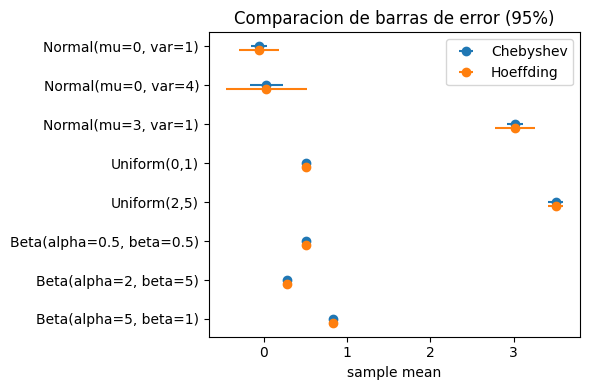

In [5]:

fig, ax = plt.subplots(figsize=(6, 4))
y = np.arange(len(df))
ax.errorbar(df['mean_hat'], y, xerr=df['chebyshev_width']/2, fmt='o', label='Chebyshev')
ax.errorbar(df['mean_hat'], y + 0.1, xerr=df['hoeffding_width']/2, fmt='o', label='Hoeffding')
ax.set_yticks(y)
ax.set_yticklabels(df['distribution'])
ax.invert_yaxis()
ax.set_xlabel('sample mean')
ax.set_title('Comparacion de barras de error (95%)')
ax.legend()
plt.tight_layout()


- En las distribuciones normales las barras de Hoeffding son claramente más anchas que las de Chebyshev. Para poder aplicar Hoeffding hemos introducido cotas artificiales $\mu \pm 4\sigma$, lo que induce un rango muy grande y, por tanto, intervalos muy conservadores. Chebyshev, en cambio, se basa en la varianza empírica y produce barras más ajustadas alrededor de la media muestral.

- En las uniforme donde sí conocemos el rango exacto, las barras obtenidasg por Chebyshev y Hoeffding prácticamente coinciden. Esto es coherente con la teoría: la varianza de una uniforme en $[a,b]$ es cercana al máximo posible dado el rango $(b-a)$, de modo que ambos métodos aprovechan información muy similar.

- En las Betas, todas acotadas en $[0,1]$, Hoeffding genera barras de igual longitud para las tres distribuciones (solo depende del rango). Chebyshev, en cambio, se adapta a la dispersión real: la $\text{Beta}(0.5,0.5)$ es más diseminada y da barras más anchas, mientras que las $\text{Beta}(2,5)$ y $\text{Beta}(5,1)$ están mucho más concentradas y producen barras significativamente más estrechas. Esto ilustra cómo Chebyshev se beneficia de una varianza pequeña, mientras que Hoeffding ignora la forma de la distribución más allá del rango.

En todos los casos las barras están centradas muy cerca de la media teórica, lo que indica que con $N=2000$ muestras la media muestral es un estimador muy estable.


## Problema 2 - comparar con valores teoricos
En este apartado comparo las estimaciones numéricas con los valores teóricos
de cada distribución (media, varianza y ancho de los IC), usando las fórmulas del tutorial para reconstruir los anchos de Chebyshev y Hoeffding.


Para cada distribución conocemos la media y la varianza teóricas:

- Normal $(\mu,\sigma^2)$: $\mu$, $\sigma^2$.
- Uniforme $(a,b)$: $\mu = (a+b)/2$, $\ \sigma^2 = (b-a)^2/12$.
- Beta $(\alpha,\beta)$: $\mu = \alpha/(\alpha+\beta)$,  
  $\sigma^2 = \alpha\beta / \big((\alpha+\beta)^2(\alpha+\beta+1)\big)$.

A partir de estas expresiones he construido una tabla donde comparo:

- $\hat\mu$ (media muestral) frente a $\mu_{\text{teo}}$,
- $\hat\sigma^2$ (varianza muestral) frente a $\sigma^2_{\text{teo}}$,
- el ancho del intervalo de Chebyshev usando varianza muestral
  frente al ancho usando la varianza teórica,
- el ancho del intervalo de Hoeffding obtenido a partir del rango
  teórico $[a,b]$ de cada distribución.



In [6]:
sample_size = 2000
alpha_level = 0.05  

theoretical = {
    "Normal(mu=0, var=1)": {"mean": 0.0, "var": 1.0, "bounds": (-4.0, 4.0)},
    "Normal(mu=0, var=4)": {"mean": 0.0, "var": 4.0, "bounds": (-8.0, 8.0)},
    "Normal(mu=3, var=1)": {"mean": 3.0, "var": 1.0, "bounds": (-1.0, 7.0)},
    "Uniform(0,1)": {"mean": 0.5, "var": (1.0 - 0.0) ** 2 / 12.0, "bounds": (0.0, 1.0)},
    "Uniform(2,5)": {"mean": (2.0 + 5.0) / 2.0, "var": (5.0 - 2.0) ** 2 / 12.0, "bounds": (2.0, 5.0)},
    "Beta(alpha=0.5, beta=0.5)": {"mean": 0.5 / (0.5 + 0.5), "var": 0.5 * 0.5 / (((0.5 + 0.5) ** 2) * (0.5 + 0.5 + 1.0)), "bounds": (0.0, 1.0)},
    "Beta(alpha=2, beta=5)": {"mean": 2.0 / 7.0, "var": 2.0 * 5.0 / (((7.0) ** 2) * (7.0 + 1.0)), "bounds": (0.0, 1.0)},
    "Beta(alpha=5, beta=1)": {"mean": 5.0 / 6.0, "var": 5.0 * 1.0 / (((6.0) ** 2) * (6.0 + 1.0)), "bounds": (0.0, 1.0)},
}

comparison = df.copy()
comparison['mean_theory']=comparison['distribution'].map(lambda d: theoretical[d]['mean'])
comparison['var_theory']=comparison['distribution'].map(lambda d: theoretical[d]['var'])
comparison['mean_error']=comparison['mean_hat'] - comparison['mean_theory']
comparison['var_error']=comparison['var_hat'] - comparison['var_theory']
comparison['chebyshev_width_theory'] = comparison['distribution'].map(
    lambda d: 2 * np.sqrt(theoretical[d]['var'] / (sample_size * alpha_level))
)
comparison['chebyshev_width_delta']=comparison['chebyshev_width'] - comparison['chebyshev_width_theory']
hoeff_factor = np.sqrt(np.log(2 / alpha_level) / (2 * sample_size))
comparison['hoeffding_width_theory']=comparison['distribution'].map(
    lambda d: 2 * (theoretical[d]['bounds'][1] - theoretical[d]['bounds'][0]) * hoeff_factor
)
comparison['hoeffding_width_delta']=comparison['hoeffding_width'] - comparison['hoeffding_width_theory']
cols = [
    'distribution',
    'mean_hat', 'mean_theory', 'mean_error',
    'var_hat', 'var_theory', 'var_error',
    'chebyshev_width', 'chebyshev_width_theory', 'chebyshev_width_delta',
    'hoeffding_width', 'hoeffding_width_theory', 'hoeffding_width_delta'
]
# print(comparison[cols])
display(comparison[cols])


,distribution,mean_hat,mean_theory,mean_error,var_hat,var_theory,var_error,chebyshev_width,chebyshev_width_theory,chebyshev_width_delta,hoeffding_width,hoeffding_width_theory,hoeffding_width_delta
0,"Normal(mu=0, var=1)",-0.0551,0.0000,-0.0551,1.0041,1.0000,0.0041,0.2004,0.2000,0.0004,0.4859,0.4859,0.0
1,"Normal(mu=0, var=4)",0.0322,0.0000,0.0322,3.9731,4.0000,-0.0269,0.3987,0.4000,-0.0013,0.9718,0.9718,0.0
2,"Normal(mu=3, var=1)",3.0139,3.0000,0.0139,1.0190,1.0000,0.0190,0.2019,0.2000,0.0019,0.4859,0.4859,0.0
3,"Uniform(0,1)",0.5047,0.5000,0.0047,0.0821,0.0833,-0.0013,0.0573,0.0577,-0.0004,0.0607,0.0607,0.0
4,"Uniform(2,5)",3.5007,3.5000,0.0007,0.7547,0.7500,0.0047,0.1737,0.1732,0.0005,0.1822,0.1822,0.0
5,"Beta(alpha=0.5, beta=0.5)",0.5039,0.5000,0.0039,0.1221,0.1250,-0.0029,0.0699,0.0707,-0.0008,0.0607,0.0607,0.0
6,"Beta(alpha=2, beta=5)",0.2851,0.2857,-0.0006,0.0257,0.0255,0.0002,0.0321,0.0319,0.0001,0.0607,0.0607,0.0
7,"Beta(alpha=5, beta=1)",0.8369,0.8333,0.0035,0.0197,0.0198,-0.0002,0.0280,0.0282,-0.0001,0.0607,0.0607,0.0


La tabla `comparison` recoge, para cada distribución, la comparación entre los
estimadores muestrales y los valores teóricos:

- `mean_hat` y `mean_theory`: media muestral frente a media teórica.
- `var_hat` y `var_theory`: varianza muestral frente a varianza teórica.
- `mean_error` y `var_error`: diferencias $\hat\mu - \mu_{\text{teo}}$ y
  $\hat\sigma^2 - \sigma^2_{\text{teo}}$.
- `chebyshev_width` y `chebyshev_width_theory`: anchura del IC de Chebyshev al
  $95\%$ usando la varianza muestral frente a usar la varianza teórica.
- `chebyshev_width_delta`: diferencia entre ambos anchos.
- `hoeffding_width` y `hoeffding_width_theory`: anchura del IC de Hoeffding al
  $95\%$ calculada a partir del rango usado en la tabla anterior.
- `hoeffding_width_delta`: diferencia entre ambos (que aquí es exactamente cero).

A partir de estos resultados:

- Las medias y varianzas muestrales están muy cerca de los valores teóricos en
  todas las distribuciones. Por ejemplo, para $N(0,1)$ se obtiene
  `mean_hat = -0.0551` y `var_hat ≈ 1.0041`, y para la uniforme $(0,1)$
  `mean_hat ≈ 0.5047` y `var_hat ≈ 0.0821` frente a la varianza teórica
  $1/12 ≈ 0.0833$. Los errores `mean_error` y `var_error` son pequeños
  (del orden de $10^{-2}$–$10^{-3}$), lo que es razonable con $N = 2000$.

- El ancho de Chebyshev calculado con la varianza muestral casi coincide con el
  ancho teórico que se obtendría usando $\sigma^2$ exacta. Las columnas
  `chebyshev_width` y `chebyshev_width_theory` difieren solo en unas milésimas
  (`chebyshev_width_delta` está siempre cerca de $0$), lo que confirma que el
  uso de la varianza estimada apenas afecta al intervalo cuando el tamaño
  muestral es grande.

- Para Hoeffding, el ancho teórico y el empírico son idénticos
  (`hoeffding_width_delta = 0.0` en todas las filas), porque el intervalo solo
  depende del rango $[a,b]$, de $N$ y de $\alpha$. En las uniformes y betas el
  rango es el soporte real de la distribución, y en las normales se ha tomado
  el truncado práctico $\mu \pm 4\sigma$ para poder aplicar la desigualdad.

En conjunto, esta comparación muestra que las simulaciones reproducen bien los
valores teóricos de media y varianza, y que los anchos de los intervalos de
Chebyshev y Hoeffding calculados numéricamente son consistentes con las
expresiones analíticas.

## Problema 3 - regla 68–95–99.7

La regla $68$–$95$–$99.7$ dice que, para una variable aproximadamente normal
$X \sim \mathcal N(\mu,\sigma^2)$, se espera que

- $P(|X-\mu| \le \sigma) \approx 0.68$,
- $P(|X-\mu| \le 2\sigma) \approx 0.95$,
- $P(|X-\mu| \le 3\sigma) \approx 0.997$.

Para comprobar en qué distribuciones se cumple esta regla uso las mismas
muestras guardadas en `samples` y, para cada distribución, calculo la proporción
de observaciones que caen dentro de $1\sigma$, $2\sigma$ y $3\sigma$ respecto a
la media muestral. Estas proporciones se guardan en las columnas
`p_1sigma`, `p_2sigma` y `p_3sigma` del `DataFrame` `cover_df`, y luego se
comparan con los valores de referencia $(0.68, 0.95, 0.997)$.

In [7]:
cover_rows = []
for name, data in samples.items():
    mean_hat=data.mean()
    std_hat=data.std(ddof=1)
    p_1=np.mean(np.abs(data - mean_hat) <= 1 * std_hat)
    p_2=np.mean(np.abs(data - mean_hat) <= 2 * std_hat)
    p_3=np.mean(np.abs(data - mean_hat) <= 3 * std_hat)
    cover_rows.append(dict(
        distribution=name,
        mean_hat=mean_hat,
        std_hat=std_hat,
        p_1sigma=p_1,
        p_2sigma=p_2,
        p_3sigma=p_3
    ))
cover_df=pd.DataFrame(cover_rows)
rule_vals = {'rule_1sigma': 0.68, 'rule_2sigma': 0.95, 'rule_3sigma': 0.997}
for col, val in rule_vals.items():
    cover_df[col] = val
cover_df['delta_1sigma']=cover_df['p_1sigma'] - cover_df['rule_1sigma']
cover_df['delta_2sigma']=cover_df['p_2sigma'] - cover_df['rule_2sigma']
cover_df['delta_3sigma']=cover_df['p_3sigma'] - cover_df['rule_3sigma']
pd.set_option('display.precision', 4)
display(cover_df[['distribution', 'p_1sigma', 'p_2sigma', 'p_3sigma',
                'delta_1sigma', 'delta_2sigma', 'delta_3sigma']])



,distribution,p_1sigma,p_2sigma,p_3sigma,delta_1sigma,delta_2sigma,delta_3sigma
0,"Normal(mu=0, var=1)",0.6815,0.9520,0.9990,0.0015,0.0020,0.0020
1,"Normal(mu=0, var=4)",0.6840,0.9550,0.9980,0.0040,0.0050,0.0010
2,"Normal(mu=3, var=1)",0.6985,0.9560,0.9945,0.0185,0.0060,-0.0025
3,"Uniform(0,1)",0.5860,1.0000,1.0000,-0.0940,0.0500,0.0030
4,"Uniform(2,5)",0.5790,1.0000,1.0000,-0.1010,0.0500,0.0030
5,"Beta(alpha=0.5, beta=0.5)",0.5020,1.0000,1.0000,-0.1780,0.0500,0.0030
6,"Beta(alpha=2, beta=5)",0.6420,0.9610,0.9970,-0.0380,0.0110,0.0000
7,"Beta(alpha=5, beta=1)",0.7365,0.9475,0.9865,0.0565,-0.0025,-0.0105


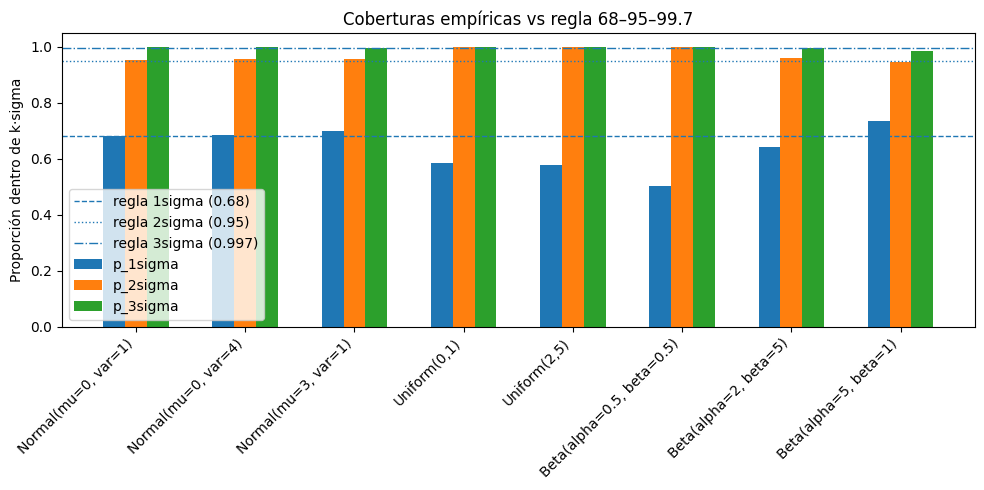

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(cover_df))
width = 0.2

ax.bar(x - width, cover_df['p_1sigma'], width, label='p_1sigma')
ax.bar(x,         cover_df['p_2sigma'], width, label='p_2sigma')
ax.bar(x + width, cover_df['p_3sigma'], width, label='p_3sigma')
ax.axhline(0.68, linestyle='--', linewidth=1, label='regla 1sigma (0.68)')
ax.axhline(0.95, linestyle=':',  linewidth=1, label='regla 2sigma (0.95)')
ax.axhline(0.997, linestyle='-.', linewidth=1, label='regla 3sigma (0.997)')

ax.set_xticks(x)
ax.set_xticklabels(cover_df['distribution'], rotation=45, ha='right')
ax.set_ylabel('Proporción dentro de k·sigma')
ax.set_title('Coberturas empíricas vs regla 68–95–99.7')
ax.legend()
plt.tight_layout()
plt.show()


En la tabla anterior, las columnas `p_1sigma`, `p_2sigma` y `p_3sigma` recogen
las coberturas empíricas dentro de $1\sigma$, $2\sigma$ y $3\sigma$ para cada
distribución, mientras que `delta_*` mide la diferencia respecto a los valores
de la regla $(0.68, 0.95, 0.997)$. La figura de barras muestra estas mismas
proporciones junto con las líneas horizontales de referencia de la regla.

- Normales  
  - Normal(0,1): $p_{1\sigma} \approx 0.6815$, $p_{2\sigma} \approx 0.9520$, $p_{3\sigma} \approx 0.9990$  
  - Normal(0,4): $p_{1\sigma} \approx 0.6840$, $p_{2\sigma} \approx 0.9550$, $p_{3\sigma} \approx 0.9980$  
  - Normal(3,1): $p_{1\sigma} \approx 0.6985$, $p_{2\sigma} \approx 0.9560$, $p_{3\sigma} \approx 0.9945$  

En las tres gaussianas los porcentajes están muy cerca de la regla $68$–$95$–$99.7$ (aprox. $(0.68, 0.95, 0.997)$), así que en la práctica la regla se cumple bastante bien.

- Uniformes  
  - Uniform(0,1): $p_{1\sigma} \approx 0.5860$, $p_{2\sigma} \approx 1.0000$, $p_{3\sigma} \approx 1.0000$  
  - Uniform(2,5): $p_{1\sigma} \approx 0.5790$, $p_{2\sigma} \approx 1.0000$, $p_{3\sigma} \approx 1.0000$  

Aquí las coberturas se alejan claramente de $(0.68, 0.95, 0.997)$: en $1\sigma$ nos quedamos en torno a $0.58$ y en $2\sigma$ y $3\sigma$ ya cubrimos todo el soporte, por lo que la probabilidad sube a $1.0$. La regla no tiene sentido en este caso.

- Betas  
  - Beta(0.5,0.5): $p_{1\sigma} \approx 0.5020$, $p_{2\sigma} \approx 1.0000$, $p_{3\sigma} \approx 1.0000$  
  - Beta(2,5): $p_{1\sigma} \approx 0.6420$, $p_{2\sigma} \approx 0.9610$, $p_{3\sigma} \approx 0.9970$  
  - Beta(5,1): $p_{1\sigma} \approx 0.7365$, $p_{2\sigma} \approx 0.9475$, $p_{3\sigma} \approx 0.9865$  

En Beta(0.5,0.5) los valores se desvían bastante de la regla (solo un 50 % en $1\sigma$ y 1.0 en $2\sigma$ y $3\sigma$). En Beta(2,5) y Beta(5,1) los porcentajes son más parecidos, sobre todo en $2\sigma$ y $3\sigma$, pero siguen sin encajar tan bien como en las normales.

La figura de barras resume bien esta comparación: para cada distribución se dibujan las coberturas empíricas en $1\sigma$, $2\sigma$ y $3\sigma$, junto con las líneas horizontales de la regla. En las normales las barras quedan prácticamente sobre las líneas de referencia, mientras que en las uniformes y en Beta(0.5,0.5) se ve claramente el patrón “$1\sigma$ bajo, $2\sigma$ y $3\sigma$ saturados en 1”. En las Betas (2,5) y (5,1) las barras se aproximan a las líneas, pero no llegan a alinearse del todo, lo que refuerza la idea de que solo las gaussianas siguen bien la regla.

En resumen, con estos datos la regla $68$–$95$–$99.7$ solo se ve claramente en las distribuciones normales; en las uniformes y en la Beta(0.5,0.5) falla de forma evidente, y en las Betas (2,5) y (5,1) solo se aproxima de forma parcial.

En general, lo que vemos en las coberturas encaja bastante bien con la teoría. La regla 68–95–99.7 es una propiedad típica de la distribución normal, porque describe cómo se reparte la masa alrededor de la media en una campana gaussiana.

En distribuciones que no son normales, es lógico que la regla falle:

En Uniformes: los valores están repartidos de manera plana en todo el intervalo. Cuando tomamos $\mu \pm k\sigma$, llega un punto (sobre todo en $2\sigma$ y $3\sigma$) en el que el intervalo ya cubre todo el soporte, así que la probabilidad pasa a ser $1$. En $1\sigma$ el porcentaje queda por debajo del $0.68$ porque la distribución no está concentrada alrededor de la media.
En Beta(0.5,0.5): tiene forma de U, con mucha masa en los extremos y poca en el centro. Por eso un intervalo centrado en la media captura menos puntos de los esperados por la regla, y se ve un $1\sigma$ claramente más bajo.
Las Betas (2,5) y (5,1): están más concentradas que la Beta(0.5,0.5) y visualmente son más “normales”, pero siguen siendo asimétricas y acotadas en $[0,1]$. Esto hace que en $2\sigma$ y $3\sigma$ se acerquen bastante a la regla, pero sin llegar a reproducirla exactamente.

